In [1]:
import json
import pandas as pd
import glob
import os
from itertools import chain
import numpy as np

In [2]:
exp_dir = "/home/noah/ESSL/exps/iteration4/exp6_1"
coeffs = []
exps = glob.glob(os.path.join(exp_dir, "*/"))
chromos = []
for e in exps:
    seed = e.split("/")[-2]
    with open(os.path.join(e, "outcomes.json"), "r") as f:
        results = json.load(f)
        for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
            c = list(chain.from_iterable(chromo[1]))
            c.append(seed)
            c.append(fitness[1])
            chromos.append(c)
columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
columns.append("seed")
columns.append("test acc")
columns

df = pd.DataFrame(chromos, columns=columns)
ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
indexes = {op:i for i, op in enumerate(ops)}
chromos_long = np.zeros([len(chromos), len(ops)+2])

for i, c in enumerate(chromos):
    for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
        chromos_long[i][indexes[aug]] = intensity
        chromos_long[i][-2] = int(c[-2])
        chromos_long[i][-1] = c[-1]

columns_long = list(ops) + ["seed", "fitness"]
df_long = pd.DataFrame(chromos_long, columns = columns_long)
df_long
ops
df_long

Contrast  Solarize  TranslateY     Color  VerticalFlip  HorizontalFlip  \
0         0.0  0.000000         2.0  0.000000      0.000000        0.000000   
1         0.0  0.000000         0.0  0.000000      0.000000        0.603191   
2         0.0  0.000000         0.0  0.469010      0.981939        0.000000   
3         0.0  0.428321         0.0  0.953488      0.000000        0.000000   
4         0.0  0.000000         0.0  0.443667      0.000000        0.000000   
..        ...       ...         ...       ...           ...             ...   
445       0.0  0.000000         0.0  0.594466      0.850476        0.000000   
446       0.0  0.813661         0.0  0.000000      0.000000        0.000000   
447       0.0  0.000000         3.0  0.000000      0.850476        0.000000   
448       0.0  0.000000         2.0  0.000000      0.000000        0.000000   
449       0.0  0.000000         0.0  0.161926      0.000000        0.000000   

     Brightness  Rotate  Sharpness  TranslateX    ShearX    ShearY  seed  \
0      0.000000    22.0   0.000000         7.0  0.000000  0.000000   7.0   
1      1.314937     0.0   0.000000         0.0  0.000000  0.126119   7.0   
2      0.000000     0.0   0.000000         0.0  0.041533  0.000000   7.0   
3      0.000000     0.0   0.668222         0.0  0.000000  0.000000   7.0   
4      0.000000     0.0   0.000000        10.0  0.136720  0.000000   7.0   
..          ...     ...        ...         ...       ...       ...   ...   
445    0.000000     0.0   0.000000         0.0  0.104604  0.000000   8.0   
446    0.918928     0.0   0.000000         0.0  0.126433  0.000000   8.0   
447    0.000000     0.0   0.000000         8.0  0.000000  0.000000   8.0   
448    0.000000    -1.0   0.000000         0.0  0.000000  0.126119   8.0   
449    0.690515     0.0   0.000000         0.0  0.000000  0.180383   8.0   

     fitness  
0      82.84  
1      82.58  
2      82.70  
3      82.68  
4      82.62  
..       ...  
445    81.44  
446    83.67  
447    83.22  
448    84.24  
449    84.13  

[450 rows x 14 columns]

# exp 1: fit linear regression and DT regressor to dataset

In [3]:
# init cv score lists
lr_scores = []
dt_scores = []

LR score:  -0.16203887534086814
DT score:  0.2713775163494999
|--- Brightness <= 0.28
|   |--- Contrast <= 0.75
|   |   |--- ShearY <= 0.12
|   |   |   |--- Color <= 1.08
|   |   |   |   |--- ShearX <= 0.06
|   |   |   |   |   |--- ShearY <= 0.02
|   |   |   |   |   |   |--- HorizontalFlip <= 0.01
|   |   |   |   |   |   |   |--- Rotate <= 25.00
|   |   |   |   |   |   |   |   |--- Solarize <= 0.51
|   |   |   |   |   |   |   |   |   |--- Solarize <= 0.33
|   |   |   |   |   |   |   |   |   |   |--- Sharpness <= 0.61
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- Sharpness >  0.61
|   |   |   |   |   |   |   |   |   |   |   |--- value: [82.37]
|   |   |   |   |   |   |   |   |   |--- Solarize >  0.33
|   |   |   |   |   |   |   |   |   |   |--- TranslateX <= 3.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- TranslateX >  3.50
|   |   |

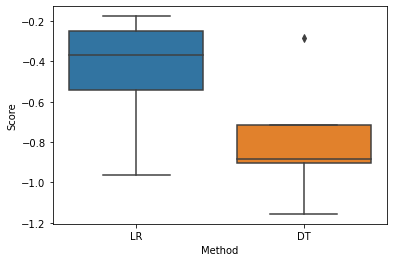

In [4]:
# fit linear regression  model to wide format data

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import export_text, plot_tree
import seaborn as sns
import matplotlib.pyplot as plt


X = df_long[ops]
y = df_long["fitness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)
reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
coeffs.append(reg.coef_)



regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
# print(cross_val_score(regressor, X, y, cv=10))
print("DT score: ", regressor.score(X_test, y_test))
regressor.get_depth()
tree = export_text(regressor, feature_names=list(ops))
print(tree)

LR = LinearRegression()
lr_scores = cross_val_score(LR, X, y, cv=5)
DT = DecisionTreeRegressor(random_state=0)
dt_scores = cross_val_score(DT, X, y, cv=5)
long_format = []
long_format+=[["LR", s] for s in lr_scores]
long_format+=[["DT", s] for s in dt_scores]
df = pd.DataFrame(long_format, columns=["Method", "Score"])
sns.boxplot(data=df, x="Method", y="Score")
plt.show()

R-squared value for DT is 0.27 and -0.16 for LR.... Terrible

# exp 2: fit linear regression and DT regressor to dataset with L2 normalization

LR score:  -0.061633052508687
DT score:  0.06762162618338186
|--- Brightness <= 0.55
|   |--- Contrast <= 0.55
|   |   |--- Color <= 0.97
|   |   |   |--- HorizontalFlip <= 0.01
|   |   |   |   |--- Rotate <= -0.29
|   |   |   |   |   |--- Rotate <= -0.53
|   |   |   |   |   |   |--- Color <= 0.56
|   |   |   |   |   |   |   |--- value: [82.90]
|   |   |   |   |   |   |--- Color >  0.56
|   |   |   |   |   |   |   |--- value: [82.71]
|   |   |   |   |   |--- Rotate >  -0.53
|   |   |   |   |   |   |--- value: [84.24]
|   |   |   |   |--- Rotate >  -0.29
|   |   |   |   |   |--- ShearY <= 0.01
|   |   |   |   |   |   |--- TranslateY <= 0.14
|   |   |   |   |   |   |   |--- ShearX <= 0.10
|   |   |   |   |   |   |   |   |--- TranslateX <= 0.15
|   |   |   |   |   |   |   |   |   |--- VerticalFlip <= 0.88
|   |   |   |   |   |   |   |   |   |   |--- ShearX <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   |   |   |   |   |--- She

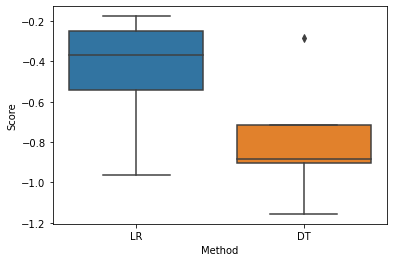

In [5]:
# normalize the data
from sklearn.preprocessing import normalize
X_train = normalize(X_train)
X_test = normalize(X_test)

reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
coeffs.append(reg.coef_)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
# print(cross_val_score(regressor, X, y, cv=10))
print("DT score: ", regressor.score(X_test, y_test))
regressor.get_depth()
tree = export_text(regressor, feature_names=list(ops))
print(tree)

LR = LinearRegression()
lr_scores = cross_val_score(LR, X, y, cv=5)
DT = DecisionTreeRegressor(random_state=0)
dt_scores = cross_val_score(DT, X, y, cv=5)
long_format = []
long_format+=[["LR", s] for s in lr_scores]
long_format+=[["DT", s] for s in dt_scores]
df = pd.DataFrame(long_format, columns=["Method", "Score"])
sns.boxplot(data=df, x="Method", y="Score")
plt.show()

Performance decreases when using l2 normalization

# exp 3: fit linear regression and DT regressor to dataset with categorical variables

In [6]:
# train with the categorical dataset
from sklearn.preprocessing import LabelEncoder
cols = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
X = df[cols]
y = df["test acc"]
for col in [f"aug{i}" for i in range(1, 4)]:
    le = LabelEncoder()
    le.fit(X[col])
    X[col] = le.transform(X[col])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)

X_train = normalize(X_train)
X_test = normalize(X_test)

reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
# coeffs.append(reg.coef_)
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
# print(cross_val_score(regressor, X, y, cv=10))
print("DT score: ", regressor.score(X_test, y_test))
regressor.get_depth()
tree = export_text(regressor, feature_names=cols)
print(tree)



KeyError: "None of [Index(['aug1', 'op1', 'aug2', 'op2', 'aug3', 'op3'], dtype='object')] are in the [columns]"

Considerably worse performance when using as categorical

# exp 4: fit linear regression and DT regressor to dataset with neutral values

LR score:  -0.10152499866110598
DT score:  0.04290551455583891
|--- Solarize <= 0.61
|   |--- ShearY <= 0.01
|   |   |--- Rotate <= 14.00
|   |   |   |--- Solarize <= 0.56
|   |   |   |   |--- Solarize <= 0.41
|   |   |   |   |   |--- VerticalFlip <= 0.49
|   |   |   |   |   |   |--- ShearX <= 0.10
|   |   |   |   |   |   |   |--- Contrast <= 1.43
|   |   |   |   |   |   |   |   |--- Color <= 0.22
|   |   |   |   |   |   |   |   |   |--- Sharpness <= 0.61
|   |   |   |   |   |   |   |   |   |   |--- Brightness <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- Brightness >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- value: [83.23]
|   |   |   |   |   |   |   |   |   |--- Sharpness >  0.61
|   |   |   |   |   |   |   |   |   |   |--- value: [82.37]
|   |   |   |   |   |   |   |   |--- Color >  0.22
|   |   |   |   |   |   |   |   |   |--- Sharpness <= 0.44
|   |   |   |   |   |   |   |   |   |   |-

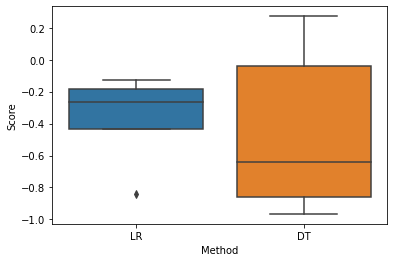

In [7]:
# apply nuetral values to missing values, everything but solarize has value of 0.0 when not applied. 
neutral = {'Brightness':0.0,
 'Color':0.0,
 'Contrast':0.0,
 'HorizontalFlip':0.0,
 'Rotate':0.0,
 'Sharpness':0.0,
 'ShearX':0.0,
 'ShearY':0.0,
 'Solarize':1.0,
 'TranslateX':0.0,
 'TranslateY':0.0,
 'VerticalFlip':0.0
          }

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import export_text, plot_tree

df_long['Solarize'] = df_long['Solarize'].apply(lambda x: 1.0 if x == 0.0 else x)
X = df_long[ops]
y = df_long["fitness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)
reg = LinearRegression().fit(X_train, y_train)
print("LR score: ", reg.score(X_test, y_test))
coeffs.append(reg.coef_) 
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)
# print(cross_val_score(regressor, X, y, cv=10))
print("DT score: ", regressor.score(X_test, y_test))
regressor.get_depth()
tree = export_text(regressor, feature_names=list(ops))
print(tree)

LR = LinearRegression()
lr_scores = cross_val_score(LR, X, y, cv=5)
DT = DecisionTreeRegressor(random_state=0)
dt_scores = cross_val_score(DT, X, y, cv=5)
long_format = []
long_format+=[["LR", s] for s in lr_scores]
long_format+=[["DT", s] for s in dt_scores]
df = pd.DataFrame(long_format, columns=["Method", "Score"])
sns.boxplot(data=df, x="Method", y="Score")
plt.show()

We do not see any improvement chanigng solarize to 1 instead of zero... this is expected. 

In [ ]:
df = pd.DataFrame(coeffs, columns = ops)

df

In [8]:
exp_dir = "/home/noah/ESSL/exps/iteration4/exp6_1"
coeffs = []
exps = glob.glob(os.path.join(exp_dir, "*/"))
# chromos = []
# for e in exps:
#     seed = e.split("/")[-2]
#     with open(os.path.join(e, "outcomes.json"), "r") as f:
#         results = json.load(f)
#         for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
#             c = list(chain.from_iterable(chromo[1]))
#             c.append(seed)
#             c.append(fitness[1])
#             chromos.append(c)
# columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
# columns.append("seed")
# columns.append("test acc")
# columns

# df = pd.DataFrame(chromos, columns=columns)
# ops = set(list(df["aug1"]) + list(df["aug2"]) +  list(df["aug3"]))
# indexes = {op:i for i, op in enumerate(ops)}
# chromos_long = np.zeros([len(chromos), len(ops)+2])

# for i, c in enumerate(chromos):
#     for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
#         chromos_long[i][indexes[aug]] = intensity
#         chromos_long[i][-2] = int(c[-2])
#         chromos_long[i][-1] = c[-1]

# columns_long = list(ops) + ["seed", "fitness"]
# df_long = pd.DataFrame(chromos_long, columns = columns_long)
# df_long
# ops
# df_long
e = exps[0]
with open(os.path.join(e, "outcomes.json"), "r") as f:
    results = json.load(f)
results

{'pop_vals': [[0, 82.84],
  [0, 82.58],
  [0, 82.7],
  [0, 82.68],
  [0, 82.62],
  [0, 82.93],
  [0, 82.44],
  [0, 82.52],
  [0, 82.91],
  [0, 82.6],
  [0, 82.55],
  [0, 82.36],
  [0, 82.93],
  [0, 83.44],
  [0, 83.4],
  [1, 82.89],
  [1, 83.03],
  [1, 83.37],
  [1, 83.11],
  [1, 82.72],
  [1, 83.22],
  [1, 82.62],
  [1, 81.93],
  [1, 82.48],
  [1, 83.36],
  [1, 81.96],
  [1, 82.5],
  [1, 82.6],
  [1, 83.44],
  [1, 83.4],
  [2, 83.11],
  [2, 82.5],
  [2, 81.96],
  [2, 83.36],
  [2, 82.12],
  [2, 82.4],
  [2, 82.84],
  [2, 81.81],
  [2, 82.71],
  [2, 82.89],
  [2, 83.35],
  [2, 82.76],
  [2, 82.42],
  [2, 83.44],
  [2, 83.4],
  [3, 82.5],
  [3, 83.36],
  [3, 82.52],
  [3, 82.13],
  [3, 81.96],
  [3, 82.84],
  [3, 82.73],
  [3, 82.9],
  [3, 83.21],
  [3, 82.56],
  [3, 82.88],
  [3, 82.93],
  [3, 83.11],
  [3, 83.44],
  [3, 83.4],
  [4, 82.64],
  [4, 82.65],
  [4, 82.19],
  [4, 82.27],
  [4, 82.9],
  [4, 82.64],
  [4, 83.1],
  [4, 81.89],
  [4, 82.67],
  [4, 82.39],
  [4, 82.4],
  [4, 82.

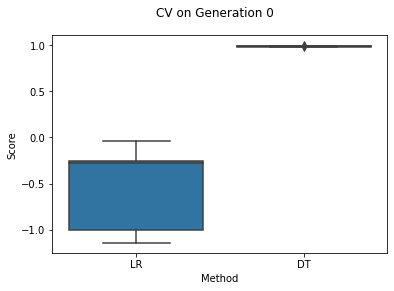

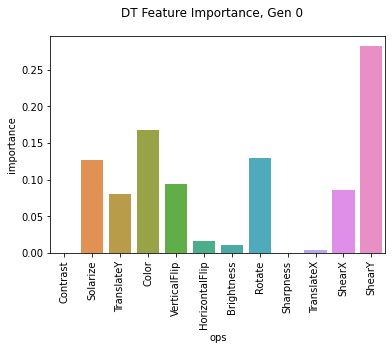

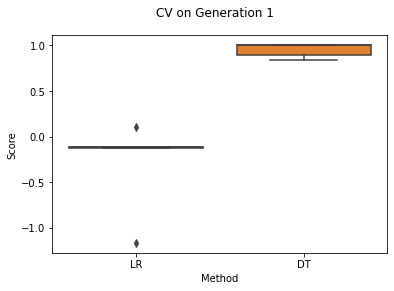

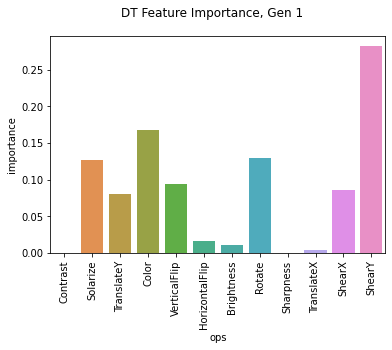

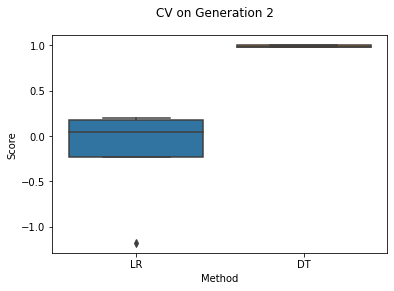

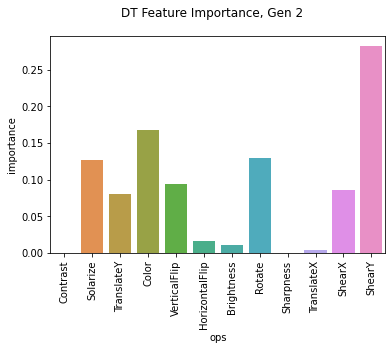

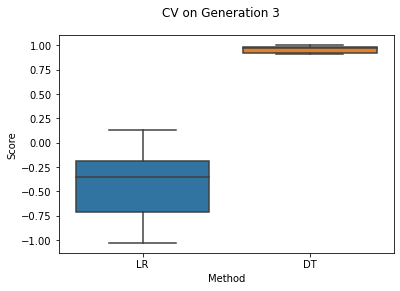

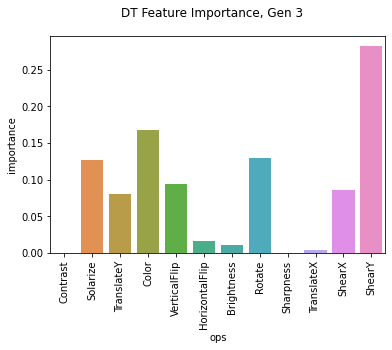

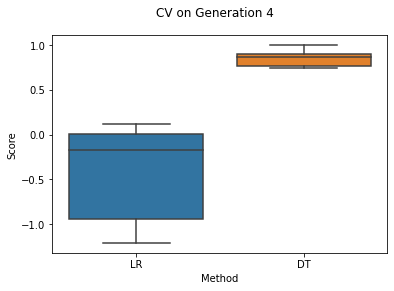

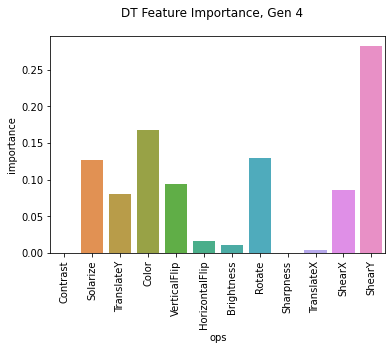

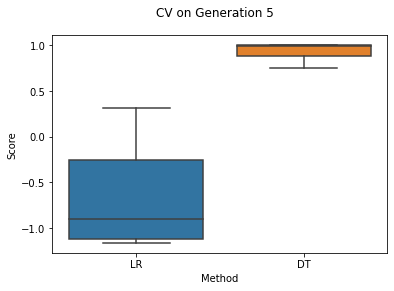

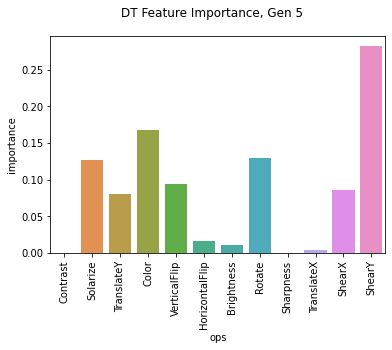

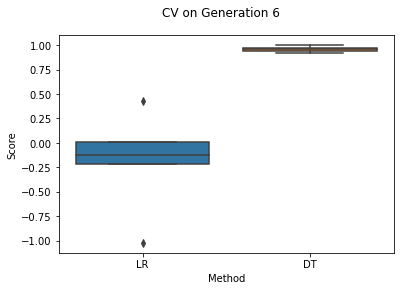

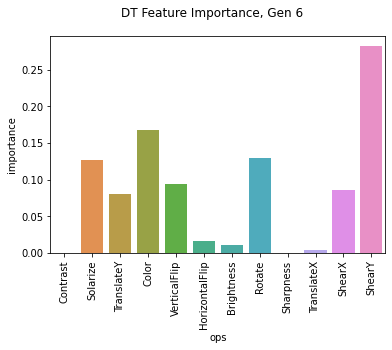

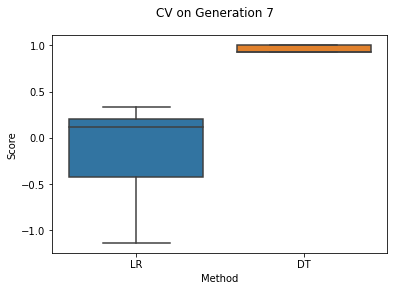

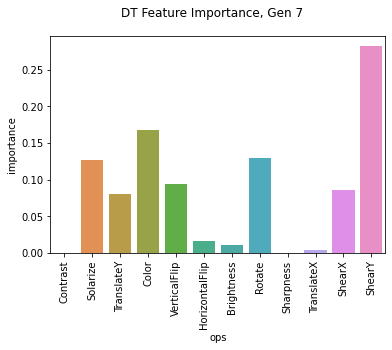

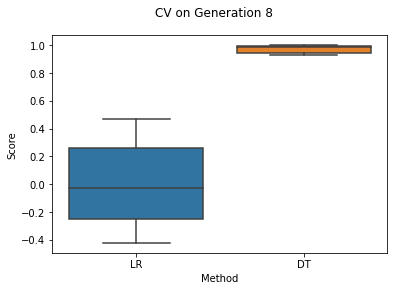

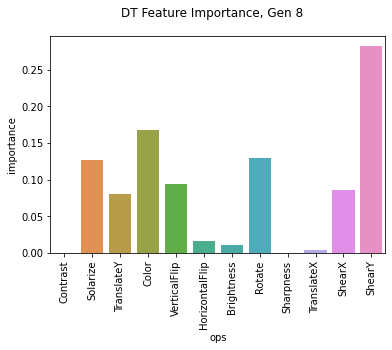

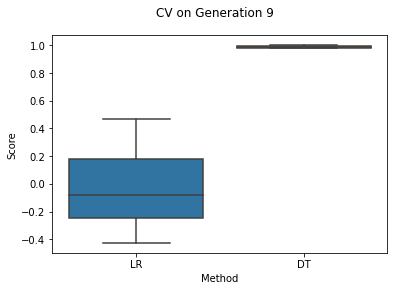

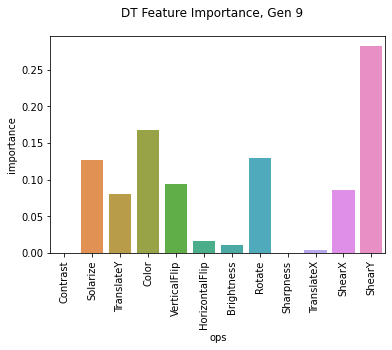

AttributeError: 'Rectangle' object has no property 'errorbar'

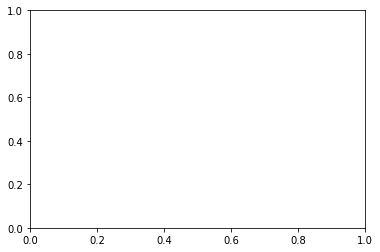

In [41]:
from collections import defaultdict
from sklearn.model_selection import KFold

exps = ["/home/noah/ESSL/exps/iteration4/exp6_0", "/home/noah/ESSL/exps/iteration4/exp6_1"]
chromos = defaultdict(list)
for e_i in exps:
    exps_i = glob.glob(os.path.join(exp_dir, "*/"))
    for e in exps_i:
        seed = e.split("/")[-2]
        with open(os.path.join(e, "outcomes.json"), "r") as f:
            results = json.load(f)
            for fitness, chromo in zip(results["pop_vals"], results["chromos"]):
                c = list(chain.from_iterable(chromo[1]))
                c.append(e_i.split("/")[-1])
                c.append(seed)
                c.append(fitness[1])
                chromos[fitness[0]].append(c)
columns = list(chain.from_iterable([[f"aug{i}", f"op{i}"] for i in range(1, 4)]))
columns.append("experiment")
columns.append("seed")
columns.append("test acc")
columns

# df = pd.DataFrame(chromos, columns=columns)
# df
total_importances = []
for gen, pop in chromos.items():
    chromos_long = np.zeros([len(pop), len(ops)+2])
    for i, c in enumerate(pop):
        for aug, intensity in zip(c[:-2][::2], c[:-2][1::2]):
            chromos_long[i][indexes[aug]] = intensity
            chromos_long[i][-2] = int(c[-2])
            chromos_long[i][-1] = c[-1]

    columns_long = list(ops) + ["seed", "fitness"]
    df_long = pd.DataFrame(chromos_long, columns = columns_long)
    X = df_long[ops].to_numpy()
    y = df_long["fitness"].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=10)
#     reg = LinearRegression().fit(X_train, y_train)
#     print("LR score: ", reg.score(X_test, y_test))
#     # coeffs.append(reg.coef_)

#     regressor = DecisionTreeRegressor(random_state=0)
#     regressor.fit(X_train, y_train)
#     print("DT score: ", regressor.score(X_test, y_test))
#     print("depth: ", regressor.get_depth())
#     importance = regressor.feature_importances_
#     print("feature importance: ", importance)
    
    # run kfold again with and get importances for each fold
    kf = KFold(n_splits=5)
    importances = []
    dt_scores = []
    for train, test in kf.split(X):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        DT = DecisionTreeRegressor(random_state=0)
        DT.fit(X_train, y_train)
        dt_scores.append(DT.score(X_test, y_test))
        for imp, op in zip(regressor.feature_importances_, ops):
            importances.append([imp, op])
        total_importances+=importances
    importance_df = pd.DataFrame(importances, columns = ["importance", "ops"])
    LR = LinearRegression()
    lr_scores = cross_val_score(LR, X, y, cv=5)
    long_format = []
    long_format+=[["LR", s] for s in lr_scores]
    long_format+=[["DT", s] for s in dt_scores]
    df = pd.DataFrame(long_format, columns=["Method", "Score"])
    sns.boxplot(data=df, x="Method", y="Score")
    plt.suptitle(f"CV on Generation {gen}")
    plt.show()
    plt.clf()
    
    sns.barplot(data = importance_df, x = "ops", y = "importance")
    plt.xticks(rotation=90)
    plt.suptitle(f"DT Feature Importance, Gen {gen}")
    plt.show()
    plt.clf()
total_importance_df = pd.DataFrame(total_importances, columns = ["importance", "ops"])
sns.barplot(data = total_importance_df, x = "ops", y = "importance")
plt.xticks(rotation=90)
plt.suptitle(f"DT Feature Importance, All Gens")
plt.show()
plt.clf()